# Chapter 3 - Regression Models 
## Segment 3 - Logistic regression

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## Logistic regression on the titanic dataset

In [4]:
address = "C:/Users/wayla/Python Data Analysis Exercise Files/Ex_Files_Python_Data_Science_EssT_Pt2/Ex_Files_Python_Data_Science_EssT_Pt2/Exercise Files/Data/titanic-training-data.csv"
titanic_training = pd.read_csv(address)
titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
print(titanic_training.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [5]:
print(titanic_training.info())#notice how not all of the columns have 891 nonnull values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


##### VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

### Checking that your target variable is binary

<Axes: xlabel='Survived', ylabel='count'>

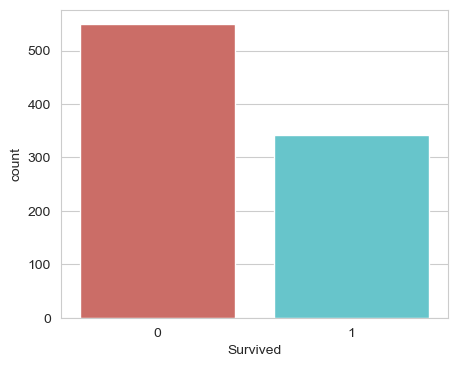

In [6]:
sb.countplot(x='Survived', data=titanic_training, palette='hls')#true is 1, false is 0

### Checking for missing values

In [7]:
titanic_training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
titanic_training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Taking care of missing values
##### Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- Survived - This variable is obviously relevant.
- Pclass - Does a passenger's class on the boat affect their survivability?
- Sex - Could a passenger's gender impact their survival rate?
- Age - Does a person's age impact their survival rate?
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [9]:
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Imputing missing values

<Axes: xlabel='Parch', ylabel='Age'>

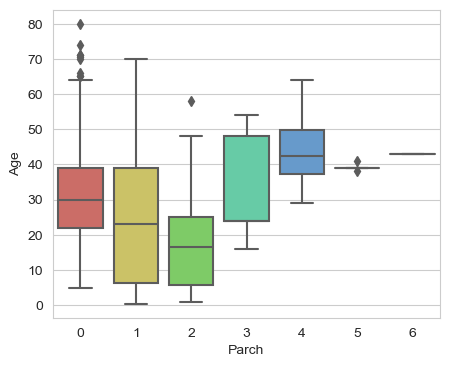

In [10]:
sb.boxplot(x='Parch', y='Age', data=titanic_data, palette='hls')#parch is the number of relatives on boat

In [11]:
Parch_groups = titanic_data.select_dtypes(include=np.number).groupby('Parch')#only take the numer values
Parch_groups.mean()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


In [12]:
Parch_groups.mean()["Age"].loc[3]

33.2

In [13]:
def age_approx(cols):#based onthe parch values, what we can do is now assign the nulls to averages instead
    Age = cols[0]
    Parch = cols[1]
    
    if pd.isnull(Age):
        return Parch_groups.mean()["Age"].loc[Parch]
        
    else:
        return Age

In [14]:
titanic_data['Age']= titanic_data[['Age', 'Parch']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [15]:
titanic_data.select_dtypes(include=np.number).groupby('Parch').mean()['Age'].loc[1], Parch_groups.mean()["Age"].loc[1]

(24.421999999999997, 24.422)

In [16]:
titanic_data.dropna(inplace=True)#dropped the two missing on the embarked dataset
titanic_data.reset_index(inplace=True, drop=True)

print(titanic_data.info())#notice how there are no nonNANs in the dataset now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB
None


### Converting categorical variables to a dummy indicators

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
gender_cat = titanic_data['Sex']
gender_cat

0        male
1      female
2      female
3      female
4        male
        ...  
884      male
885    female
886    female
887      male
888      male
Name: Sex, Length: 889, dtype: object

In [18]:
gender_encoded = label_encoder.fit_transform(gender_cat)
gender_encoded#now comes out as a binary 0(female) or 1(male)

array([1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,

In [19]:
gender_df = pd.DataFrame(gender_encoded, columns=['male_gender'])
gender_df.head()

,male_gender
0,1
1,0
2,0
3,0
4,1


In [20]:
embarked_cat = titanic_data['Embarked']
embarked_encoded = label_encoder.fit_transform(embarked_cat)
embarked_encoded[0:20]#same thing, but this one is three numbers which doesn't work for logistic regression

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0])

In [21]:
from sklearn.preprocessing import OneHotEncoder
binary_encoder = OneHotEncoder(categories='auto')
embarked_1hot = binary_encoder.fit_transform(embarked_encoded.reshape(-1, 1))
embarked_1hot_mat = embarked_1hot.toarray()
embarked_1hot_mat#now it is showing the three choices and T/F for 

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [22]:
embarked_df = pd.DataFrame(embarked_1hot_mat, columns=['C','Q','S'])
embarked_df#this is now all true or false

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
884,0.0,0.0,1.0
885,0.0,0.0,1.0
886,0.0,0.0,1.0
887,1.0,0.0,0.0


In [23]:
#now to replace it for our ataframe
titanic_data = titanic_data.drop(["Sex","Embarked"], axis=1)
titanic_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.000000,1,0,7.2500
1,2,1,1,38.000000,1,0,71.2833
2,3,1,3,26.000000,0,0,7.9250
3,4,1,1,35.000000,1,0,53.1000
4,5,0,3,35.000000,0,0,8.0500
...,...,...,...,...,...,...,...
884,887,0,2,27.000000,0,0,13.0000
885,888,1,1,19.000000,0,0,30.0000
886,889,0,3,17.216912,1,2,23.4500
887,890,1,1,26.000000,0,0,30.0000


In [24]:
titanic_newdf = pd.concat([titanic_data, gender_df, embarked_df], axis=1, verify_integrity=True).astype(float)
titanic_newdf

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male_gender,C,Q,S
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
884,887.0,0.0,2.0,27.000000,0.0,0.0,13.0000,1.0,0.0,0.0,1.0
885,888.0,1.0,1.0,19.000000,0.0,0.0,30.0000,0.0,0.0,0.0,1.0
886,889.0,0.0,3.0,17.216912,1.0,2.0,23.4500,0.0,0.0,0.0,1.0
887,890.0,1.0,1.0,26.000000,0.0,0.0,30.0000,1.0,1.0,0.0,0.0


### Checking for independence between features

<Axes: >

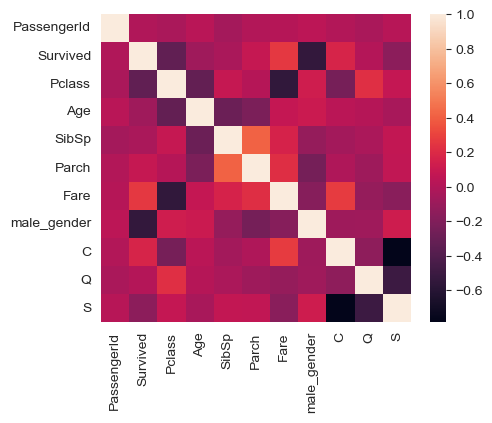

In [25]:
sb.heatmap(titanic_newdf.corr())

In [26]:
#looks like the class and fare are correlated (lower 1st & 2nd class = higher fare paid), so lets drop those so that we only see the correlation between the values we chose
titanic_newdf.drop(['Fare','Pclass'], axis = 1, inplace=True)

In [27]:
titanic_newdf #there are 6 predictive features in this dataset, 6*50 = 300 rows of data to be sufficient for accurate logistic regression

,PassengerId,Survived,Age,SibSp,Parch,male_gender,C,Q,S
0,1.0,0.0,22.000000,1.0,0.0,1.0,0.0,0.0,1.0
1,2.0,1.0,38.000000,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,1.0,26.000000,0.0,0.0,0.0,0.0,0.0,1.0
3,4.0,1.0,35.000000,1.0,0.0,0.0,0.0,0.0,1.0
4,5.0,0.0,35.000000,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
884,887.0,0.0,27.000000,0.0,0.0,1.0,0.0,0.0,1.0
885,888.0,1.0,19.000000,0.0,0.0,0.0,0.0,0.0,1.0
886,889.0,0.0,17.216912,1.0,2.0,0.0,0.0,0.0,1.0
887,890.0,1.0,26.000000,0.0,0.0,1.0,1.0,0.0,0.0


### Checking that your dataset size is sufficient

In [28]:
titanic_newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    float64
 1   Survived     889 non-null    float64
 2   Age          889 non-null    float64
 3   SibSp        889 non-null    float64
 4   Parch        889 non-null    float64
 5   male_gender  889 non-null    float64
 6   C            889 non-null    float64
 7   Q            889 non-null    float64
 8   S            889 non-null    float64
dtypes: float64(9)
memory usage: 62.6 KB


In [30]:
X_train, X_test, y_train, y_test = train_test_split(titanic_data.drop('Survived', axis=1), #what we're using to make a prediction
                                                   titanic_data['Survived'], test_size=0.2,
                                                   random_state=200)

In [31]:
X_train

,PassengerId,Pclass,Age,SibSp,Parch,Fare
719,721,2,6.000,0,1,33.0000
165,167,1,24.422,0,1,55.0000
879,882,3,33.000,0,0,7.8958
451,453,1,30.000,0,0,27.7500
181,183,3,9.000,4,2,31.3875
...,...,...,...,...,...,...
810,812,3,39.000,0,0,24.1500
836,839,3,32.000,0,0,56.4958
784,786,3,25.000,0,0,7.2500
617,619,2,4.000,2,1,39.0000


In [32]:
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare
45,46,3,32.178503,0,0,8.0500
873,876,3,15.000000,0,0,7.2250
435,437,3,21.000000,2,2,34.3750
129,131,3,33.000000,0,0,7.8958
713,715,2,52.000000,0,0,13.0000
...,...,...,...,...,...,...
179,181,3,17.216912,8,2,69.5500
337,339,3,45.000000,0,0,8.0500
57,58,3,28.500000,0,0,7.2292
618,620,2,26.000000,0,0,10.5000


In [33]:
y_train

719    1
165    1
879    0
451    0
181    0
      ..
810    0
836    1
784    0
617    1
794    0
Name: Survived, Length: 711, dtype: int64

In [34]:
y_test

45     0
873    1
435    0
129    0
713    0
      ..
179    0
337    1
57     0
618    0
548    1
Name: Survived, Length: 178, dtype: int64

### Deploying and evaluating the model

## Model Evaluation
### Classification report without cross-validation

### K-fold cross-validation & confusion matrices

### Make a test prediction